In [1]:
from numpy import *
import pandas as pd

# SVD++

In [2]:
def gradAscent(data,K,alpha,beta,maxCycles):
    '''
    data: user-item rating matrix
    K: the number of features (assume smaller than the no. of user and items)
    alpha: learning rate
    beta: regularization parameter
    maxCycles: no. of iterations
    '''
    R=mat(data)
    m,n=shape(R)
    
#   initialize user and item latent feature matrix
    p=mat(random.random((m,K)))
    q=mat(random.random((K,n)))
    
#   initialize the bisases
    bu=zeros(m)
    bd=zeros(n)
    b=mean(R[where(R!=0)])
    
#   gradient descent
    ls=[]
    for step in range(maxCycles):
        for i in range(m):
            for j in range(n):
                if R[i,j] >0:
                    r=R[i,j]
                    pq=0.0
                    for k in range(K):
                        pq+=p[i,k]*q[k,j]
                    e = r-b-bu[i]-bd[j]-pq
#                   Update user and item latent feature matrix
                    bu[i] = bu[i] + alpha*(2*e-beta*bu[i])
                    bd[j] = bd[j] + alpha*(2*e-beta*bd[j])
#                   Update biases
                    for k in range(K):
                        p[i,k] += alpha*(2*e*q[k,j]-beta*p[i,k])
                        q[k,j] += alpha*(2*e*p[i,k]-beta*q[k,j])    

#       calculate loss         
        loss=0.0
        for i in range(m):
            for j in range(n):
                bb=0.0
                dd=0.0
                pq2=0.0
                pq=0
                if R[i,j] > 0:
                    r=R[i,j]
                    bb +=bu[i]**2
                    dd +=bd[j]**2
                    for k in range(K):
                        pq2 +=p[i,k]**2+q[k,j]**2
                        pq +=p[i,k]*q[k,j]
                    
                    loss=(r-b-bu[i]-bd[j]-pq)**2+beta*(bb+dd+pq2)/2

        ls.append(loss)

        if loss<0.0001:
            break
        if step %1000==0:
            print(loss)
    
    return p,q,b,bu,bd,ls

In [3]:
# test on a small sample set
R = mat([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4]])


In [4]:
if __name__ == "__main__":
    p, q, b, bu, bd, ls = gradAscent(R,3,0.0002,0.02,10000)
    
    m,n=shape(R)
    
    bu=list(bu.reshape(m,1))
    bu=broadcast_to(bu,(m,n))
    
    bd=broadcast_to(bd,(m,n))
    
    result = b+bu+bd+p*q
    
    print(result)

0.856523276163
0.0875302625331
0.0524067385546
0.0530254037105
0.052268654279
0.0521082435059
0.0520507254201
0.0519239481276
0.0517095163844
0.0514249544425
[[ 4.98595827  2.99234488  3.62115856  1.0156667 ]
 [ 3.99325266  2.18754982  3.23347954  1.01275902]
 [ 1.02102858  0.98361577  5.41321644  4.98486837]
 [ 1.00130492  0.71038106  4.68801997  3.98955391]
 [ 1.5303263   1.0352638   4.98624638  3.9956678 ]]


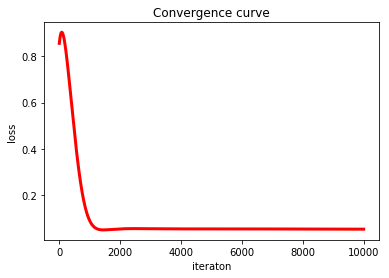

In [5]:
# Check Convergence 
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ls)), ls, color='r',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('iteraton')
plt.ylabel('loss')


# Moive Recommder System based on SVD++

This data set contains 100,000 ratings (1-5) from 943 users on 1682 movies. The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. Source URL: https://grouplens.org/datasets/movielens/100k/

In [3]:
from surprise import SVDpp
from surprise import Dataset
from surprise.model_selection import cross_validate

In [4]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /Users/chenxian/.surprise_data/ml-100k


In [8]:
algo = SVDpp()

In [10]:
cross_validate(algo,data,measures=['RMSE','MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9238  0.9154  0.9257  0.9207  0.9130  0.9197  0.0048  
MAE (testset)     0.7268  0.7222  0.7258  0.7200  0.7179  0.7225  0.0033  
Fit time          239.69  232.94  224.31  231.68  258.98  237.52  11.79   
Test time         3.85    3.88    3.46    3.69    3.79    3.73    0.15    


{'fit_time': (239.69034695625305,
  232.93804383277893,
  224.30923509597778,
  231.67732906341553,
  258.9827971458435),
 'test_mae': array([ 0.72678327,  0.72218598,  0.72575526,  0.72003387,  0.71792656]),
 'test_rmse': array([ 0.92379001,  0.91542607,  0.92566785,  0.92073923,  0.9130041 ]),
 'test_time': (3.846879005432129,
  3.8829410076141357,
  3.461089849472046,
  3.692612886428833,
  3.7882609367370605)}

In [11]:
from surprise import accuracy
from surprise.model_selection import train_test_split

In [12]:
#split traning and testing set (25%)
trainset, testset = train_test_split(data, test_size = 0.25)

#train SVD++ on the training set and predict ratings for the testing set
predictions = algo.fit(trainset).test(testset)

#compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9234


0.92335218625386495

# SVD

In [12]:
def gradAscent2(data, K,alpha,beta,maxCycles):
    '''
    data: user-item rating matrix
    K: the number of latent dimensions 
    alpha: learning rate
    beta: regularization parameter
    maxCycles: no. of iterations
    '''
    dataMat = mat(data)
    m, n = shape(dataMat)
    p = mat(random.random((m, K)))
    q = mat(random.random((K, n)))

    ls=[]
    for step in range(maxCycles):
        for i in range(m):
            for j in range(n):
                if dataMat[i,j] > 0:
                    error = dataMat[i,j]
                    for k in range(K):
                        error = error - p[i,k]*q[k,j]
                    for k in range(K):
                        p[i,k] = p[i,k] + alpha * (2 * error * q[k,j] - beta * p[i,k])
                        q[k,j] = q[k,j] + alpha * (2 * error * p[i,k] - beta * q[k,j])

        loss = 0.0
        for i in range(m):
            for j in range(n):
                if dataMat[i,j] > 0:
                    error = 0.0
                    for k in range(K):
                        error = error + p[i,k]*q[k,j]
                    loss = (dataMat[i,j] - error) * (dataMat[i,j] - error)
                    for k in range(K):
                        loss = loss + beta * (p[i,k] * p[i,k] + q[k,j] * q[k,j]) / 2
        
        ls.append(loss)
        
        if loss < 0.001:
            break
        
        if step % 1000 == 0:
            print (loss)

    return p, q, ls


In [13]:
if __name__ == "__main__":
    '''
    test the model on a small sample set
    '''
    p, q, ls= gradAscent2(R,3,alpha = 0.0002,beta = 0.02,10000) #alpha: learning rate, beta: regularization parameter
    result = p*q
    print(result)

10.2481523434
0.113763832946
0.10484625791
0.101993644909
0.100610463125
0.0998412596373
0.0993424134791
0.0989453915735
0.0985898714034
0.098256509064
[[ 4.97781815  2.98142358  4.61777884  1.00281913]
 [ 3.98185777  2.4891703   3.58797606  1.00091279]
 [ 1.00505184  0.98795238  3.82224815  4.97036883]
 [ 0.9976844   0.66753871  3.82432313  3.98328448]
 [ 1.8845386   1.01259227  4.9836503   3.98857821]]


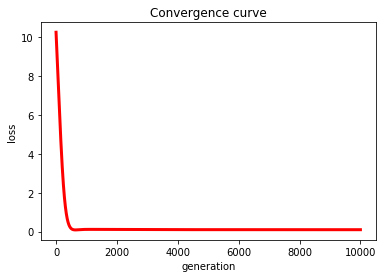

In [14]:
# check convergence
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(range(len(ls)), ls, color='r',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('generation')
plt.ylabel('loss')